In [1]:
# see https://github.com/JustGlowing/minisom/blob/master/examples/HexagonalTopology.ipynb
# maybe look at this??? https://github.com/JustGlowing/minisom/blob/master/examples/DemocracyIndex.ipynb
from minisom import MiniSom

import pandas as pd
import numpy as np
import anndata as ad

import matplotlib.pyplot as plt
from matplotlib.patches import RegularPolygon, Ellipse
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib import cm, colorbar
from matplotlib.lines import Line2D

# display matplotlib plots in notebook
%matplotlib inline
# display bokeh plot in notebook

In [2]:
input_dir_w6 = "/home/users/kzlin/kzlinlab/projects/scContrastiveLearn/out/kevin/Writeup6/"
# Load dataset

train_embeddings = np.load(input_dir_w6+'scBaseEncoderFeat_Z_bs250_tau0.5.npy')
print(train_embeddings.shape)

(41093, 5)


In [3]:
input_dir_w5 = "/home/users/kzlin/kzlinlab/projects/scContrastiveLearn/out/kevin/Writeup5/"

adata_train = ad.read_h5ad(input_dir_w5+'Larry_41093_2000_norm_log_cleaned.h5ad')

# adata_train.obs['Cell type annotation'] = adata_train.obs["cell_type"]
# adata_test.obs['Cell type annotation'] = adata_test.obs["cell_type"]
train_labels = adata_train.obs["clone_id"].to_numpy()
print(train_labels.shape)

(41093,)


In [4]:
adata_train

AnnData object with n_obs × n_vars = 41093 × 2000
    obs: 'Library', 'Cell barcode', 'time_info', 'Starting population', 'state_info', 'Well', 'SPRING-x', 'SPRING-y', 'Time point', 'clone_id', 'n_genes'
    var: 'Accession', 'Chromosome', 'End', 'Start', 'Strand', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'data_des', 'hvg', 'log1p'
    obsm: 'X_clone', 'X_emb'
    layers: 'raw_counts'

In [5]:
# Assuming adata_train.obs['clone_id'] is a pandas Series
# Add the 'Lineage_' prefix to each numerical value
adata_train.obs['clone_id'] = adata_train.obs['clone_id'].apply(lambda x: f"Lineage_{x}")

# Check the first few entries to confirm
print(adata_train.obs['clone_id'].head())

d6_2_2:GCGTGCAAAGAAGTTA     Lineage_573
d6_2_2:AAGGGACCCTCGATGC    Lineage_1440
d6_2_2:CGTACCGAAGCGCCTT     Lineage_394
d6_2_2:CCGTAGCTAGGCAGTT    Lineage_1972
d6_2_2:TAGGCTTTCGTGGATA    Lineage_1450
Name: clone_id, dtype: object


In [6]:
# include the embedding into the object
# Assuming 'embedding' is a DataFrame of shape (n_cells, n_components)
adata_train.obsm['X_LCL'] = train_embeddings

In [7]:
# Create a boolean mask based on the condition in adata_train
mask = (adata_train.obs["time_info"] == 2.0)
# Subset adata_train based on the mask
adata_train = adata_train[mask]

In [8]:
# now I only want to keep relevant lineages
import pandas as pd

# Replace 'file.csv' with the path to your CSV file
df = pd.read_csv('/home/users/kzlin/kzlinlab/projects/scContrastiveLearn/git/SCSeq_LineageBarcoding_kevin/csv/kevin/Writeup6/LARRY_lineage_day-6_statistics.csv')

# To preview the first 5 rows of the dataframe
print(df.head())
print(df.shape)

     Unnamed: 0  Monocyte  Neutrophil  Undifferentiated  Other  \
0     Lineage_0         0           0                 3      0   
1     Lineage_1         0           7                 0      0   
2    Lineage_10         0           1                10      0   
3  Lineage_1003         1           1                 4      0   
4  Lineage_1004         0           9                 3      0   

   Monocyte_proportion  Neutrophil_proportion  Undifferentiated_proportion  \
0             0.000000               0.000000                     1.000000   
1             0.000000               1.000000                     0.000000   
2             0.000000               0.090909                     0.909091   
3             0.166667               0.166667                     0.666667   
4             0.000000               0.750000                     0.250000   

   Other_proportion  lineage_size   entropy  
0               0.0             3  1.000000  
1               0.0             7  0.00000

In [9]:
# Assuming your DataFrame is already loaded as 'df'
# Filter rows where 'Other_proportion' is less than 0.05
filtered_df = df[df['Other_proportion'] < 0.05]

# Select only the 'Unnamed: 0' column (which contains the Lineage names)
lineage_names = filtered_df['Unnamed: 0']

# Output the result
print(lineage_names)

0          Lineage_0
1          Lineage_1
2         Lineage_10
3       Lineage_1003
4       Lineage_1004
            ...     
2574     Lineage_991
2575     Lineage_992
2576     Lineage_995
2577     Lineage_996
2578     Lineage_997
Name: Unnamed: 0, Length: 1889, dtype: object


In [10]:
# Assuming lineage_names_list contains the clone_id values you want to keep
# Filter adata_train based on whether clone_id is in lineage_names_list
subset_adata_train = adata_train[adata_train.obs['clone_id'].isin(lineage_names)].copy()

# Check the result
print(subset_adata_train)

AnnData object with n_obs × n_vars = 975 × 2000
    obs: 'Library', 'Cell barcode', 'time_info', 'Starting population', 'state_info', 'Well', 'SPRING-x', 'SPRING-y', 'Time point', 'clone_id', 'n_genes'
    var: 'Accession', 'Chromosome', 'End', 'Start', 'Strand', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'data_des', 'hvg', 'log1p'
    obsm: 'X_clone', 'X_emb', 'X_LCL'
    layers: 'raw_counts'


In [11]:
print(subset_adata_train.obs['time_info'].value_counts())

print(subset_adata_train.obs['state_info'].value_counts())

time_info
2.0    975
Name: count, dtype: int64
state_info
Undifferentiated    966
Monocyte              2
Neutrophil            2
Baso                  1
Mast                  1
Erythroid             1
Ccr7_DC               1
Meg                   1
Name: count, dtype: int64


In [12]:
# Filter adata to keep only the rows where 'state_info' is 'Undifferentiated'
subset_adata_train = subset_adata_train[subset_adata_train.obs['state_info'] == 'Undifferentiated'].copy()

# Check the result to confirm the filtering
print(subset_adata_train.obs['state_info'].value_counts())

state_info
Undifferentiated    966
Name: count, dtype: int64


In [13]:
subset_adata_train

AnnData object with n_obs × n_vars = 966 × 2000
    obs: 'Library', 'Cell barcode', 'time_info', 'Starting population', 'state_info', 'Well', 'SPRING-x', 'SPRING-y', 'Time point', 'clone_id', 'n_genes'
    var: 'Accession', 'Chromosome', 'End', 'Start', 'Strand', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'data_des', 'hvg', 'log1p'
    obsm: 'X_clone', 'X_emb', 'X_LCL'
    layers: 'raw_counts'

In [14]:
# Subset train_embeddings based on the same mask
train_embeddings_subset = subset_adata_train.obsm['X_LCL']
print(train_embeddings_subset.shape)

(966, 5)


In [15]:
grid_size = 10
som = MiniSom(grid_size, grid_size,train_embeddings_subset.shape[1], sigma=3, learning_rate=.5, activation_distance='euclidean',
              topology='hexagonal', neighborhood_function='gaussian', random_seed=10)

som.train(train_embeddings_subset, 100000, verbose=True)

 [ 100000 / 100000 ] 100% - 0:00:00 left 
 quantization error: 0.18720524579453213


In [16]:
# Get the weights of the SOM after training
weights = som.get_weights()

# Calculate the U-matrix for visualization
umatrix = som.distance_map()

xx, yy = som.get_euclidean_coordinates()

In [17]:
# Neighboring indices for even and odd rows
ii_even = [1, 1, 1, 0, -1, 0] 
jj_even = [1, 0, -1, -1, 0, 1]
ii_odd = [0, 1, 0, -1, -1, -1]
jj_odd = [1, 0, -1, -1, 0, 1]
        
class SOMClustering:
    def __init__(self, som_weights, topology='hexagonal', max_cluster_size=None):
        self.som_weights = som_weights  # SOM weights (neurons x features)
        self.topology = topology
        self.distances = None  # Distance map to store distances between neighbors
        self.segments = None   # Segment labels for each neuron
        self.max_cluster_size = max_cluster_size  # Max size for any single cluster
    
    def calculate_distance_map(self):
        """Calculates the distance between adjacent neurons."""
        rows, cols = self.som_weights.shape[0], self.som_weights.shape[1]
        distance_map = np.full((rows, cols, 6), np.nan)  # 6 neighbors for hex topology
        
        for x in range(rows):
            for y in range(cols):
                w_2 = self.som_weights[x, y]
                neighbors = ii_even if y % 2 == 0 else ii_odd
                jj = jj_even if y % 2 == 0 else jj_odd
                for k, (i, j) in enumerate(zip(neighbors, jj)):
                    if 0 <= x + i < rows and 0 <= y + j < cols:
                        w_1 = self.som_weights[x + i, y + j]
                        distance_map[x, y, k] = np.linalg.norm(w_2 - w_1)
                        
        return distance_map
    
    def merge_segments(self, distance_map, num_segments):
        """Merges segments based on distance until the desired number of segments is reached."""
        rows, cols = self.som_weights.shape[0], self.som_weights.shape[1]
        segment_labels = np.arange(rows * cols).reshape(rows, cols)  # Each neuron starts as its own segment

        # Precompute and update cluster sizes
        cluster_sizes = {i: 1 for i in np.unique(segment_labels)}  # Initially, each neuron is its own cluster

        while np.unique(segment_labels).size > num_segments:
            min_dist = np.inf
            to_merge = None
            
            for x in range(rows):
                for y in range(cols):
                    for k, dist in enumerate(distance_map[x, y]):
                        if not np.isnan(dist) and dist < min_dist:
                            nx, ny = x + (ii_even[k] if y % 2 == 0 else ii_odd[k]), y + (jj_even[k] if y % 2 == 0 else jj_odd[k])
                            if 0 <= nx < rows and 0 <= ny < cols and segment_labels[x, y] != segment_labels[nx, ny]:
                                seg1 = segment_labels[x, y]
                                seg2 = segment_labels[nx, ny]
                                # Check if merging would exceed the max cluster size
                                size_seg1 = cluster_sizes[seg1]
                                size_seg2 = cluster_sizes[seg2]
                                if self.max_cluster_size is None or (size_seg1 + size_seg2 <= self.max_cluster_size):
                                    min_dist = dist
                                    to_merge = ((x, y), (nx, ny))
            
            # Break the loop if no valid merges are found (prevents infinite loops)
            if to_merge is None:
                break
            
            # Merge the segments
            seg1, seg2 = segment_labels[to_merge[0]], segment_labels[to_merge[1]]
            segment_labels[segment_labels == seg2] = seg1  # Merge segments
            cluster_sizes[seg1] += cluster_sizes.pop(seg2)  # Update cluster size
            
            # Update the distance map for the newly merged segment
            self.update_distances(segment_labels, distance_map)
        
        return segment_labels
    
    def update_distances(self, segment_labels, distance_map):
        """Update the distances between segments after a merge."""
        rows, cols = segment_labels.shape

        # Recalculate distances between neurons that are in different segments
        for x in range(rows):
            for y in range(cols):
                for k, dist in enumerate(distance_map[x, y]):
                    if not np.isnan(dist):
                        nx, ny = x + (ii_even[k] if y % 2 == 0 else ii_odd[k]), y + (jj_even[k] if y % 2 == 0 else jj_odd[k])
                        if 0 <= nx < rows and 0 <= ny < cols and segment_labels[x, y] != segment_labels[nx, ny]:
                            distance_map[x, y, k] = np.linalg.norm(self.som_weights[x, y] - self.som_weights[nx, ny])
    
    def fit(self, num_segments=8):
        """Performs the SOM clustering."""
        # Step 1: Calculate the distance map
        distance_map = self.calculate_distance_map()
        
        # Step 2: Merge segments iteratively until num_segments are reached
        self.segments = self.merge_segments(distance_map, num_segments)
        
        return self.segments

In [18]:
# Assume som_weights is a 2D array of neurons (rows, cols, features)
num_segments = 6
som_clustering = SOMClustering(weights, max_cluster_size=grid_size**2/num_segments)
segments = som_clustering.fit(num_segments=num_segments)

print(segments)  # Each neuron now has a segment label

[[ 15  15  15  15  15  15  82  82  82  82  82  42  42  42  42]
 [ 15  15  15  15  15  15  82  82  82  82  82  82  42  42  42]
 [ 15  15  15  15  15  82  82  82  82  82  82  82  42  42  42]
 [ 15  15  15  15  15  50  50  50  82  82  82  82  42  42  42]
 [ 15  15  15  15  15  50  50  50  82  82  82  82  82  42  42]
 [ 15  15  15  78  50  50  50  82  82  82  82  86  86  86  42]
 [ 15  15  15  78  50  50  50  82  82  82  82  86  86  86  86]
 [105 105 105  78  50  50  50  82  82  86  86  86  86  86  86]
 [105 105 105  78  78  78  78  78  78  86  86  86  86  86  86]
 [105 105 105  78  78  78  78  78  78  86  86  86  86  86  86]
 [105 105 105  78  78  78  78  78  78  86  86  86  86  86  86]
 [105 105 105 105  78  78  78 172 172 172 172 172  86  86  86]
 [105 105 105 105  78  78  78 172 172 172 172 172  86  86  86]
 [105 105 105 105  78  78  78 172 172 172 172 172 172 172 172]
 [105 105 105 105  78  78  78 172 172 172 172 172 172 172 172]]


/tmp/ipykernel_2287765/2448964720.py:12: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('tab20', len(unique_segments))  # Use a colormap with enough colors for clusters


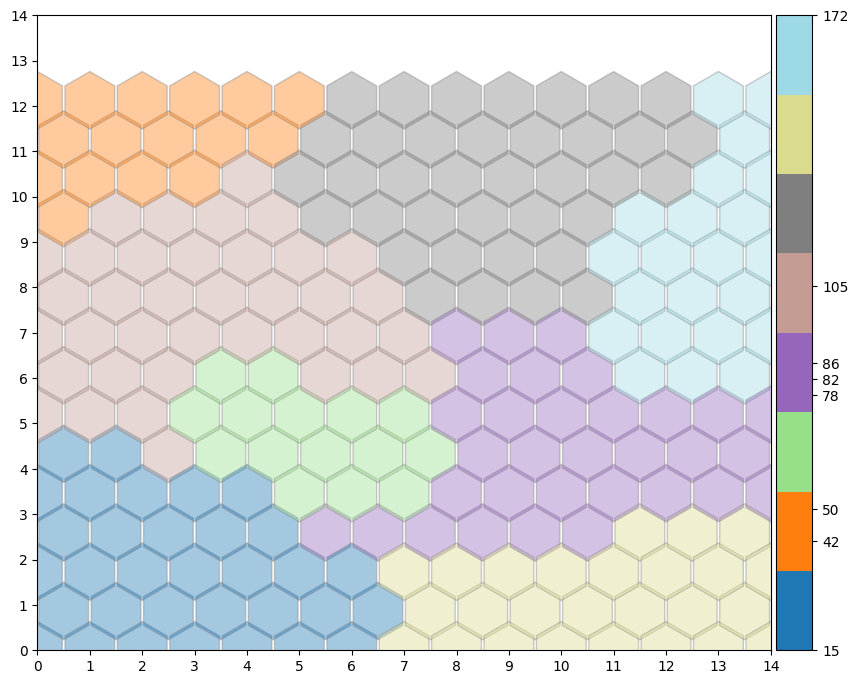

In [19]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import RegularPolygon
from matplotlib import cm
from mpl_toolkits.axes_grid1 import make_axes_locatable

# Assuming 'segments' is your 2D array where each neuron has a cluster label
# Example: segments = np.random.randint(0, 8, (20, 20))

# Create a colormap for the clusters
unique_segments = np.unique(segments)
cmap = cm.get_cmap('tab20', len(unique_segments))  # Use a colormap with enough colors for clusters

# Create a figure for the hexagonal grid visualization
f = plt.figure(figsize=(10, 10))
ax = f.add_subplot(111)

ax.set_aspect('equal')

# Create a hexagonal grid for the SOM
for i in range(weights.shape[0]):
    for j in range(weights.shape[1]):
        wy = yy[(i, j)] * np.sqrt(3) / 2
        
        # Get the cluster of the current neuron
        cluster = segments[i, j]
        
        # Use the cluster label to get a color from the colormap
        hex_color = cmap(np.where(unique_segments == cluster)[0][0])
        
        hex = RegularPolygon((xx[(i, j)], wy),
                             numVertices=6, 
                             radius=.95 / np.sqrt(3), 
                             facecolor=hex_color,  # Color by cluster
                             alpha=.4, 
                             edgecolor='gray')
        ax.add_patch(hex)

# Set the axis range and labels
xrange = np.arange(weights.shape[0])
yrange = np.arange(weights.shape[1])
plt.xticks(xrange - .5, xrange)
plt.yticks(yrange * np.sqrt(3) / 2, yrange)

# Optional: Add color bar for clusters
divider = make_axes_locatable(plt.gca())
ax_cb = divider.new_horizontal(size="5%", pad=0.05)    
plt.gcf().add_axes(ax_cb)

# Create a color bar with the unique clusters
norm = plt.Normalize(vmin=min(unique_segments), vmax=max(unique_segments))
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
plt.colorbar(sm, cax=ax_cb, ticks=unique_segments)

plt.show()

In [20]:
type(umatrix)

numpy.ndarray

<Axes: >

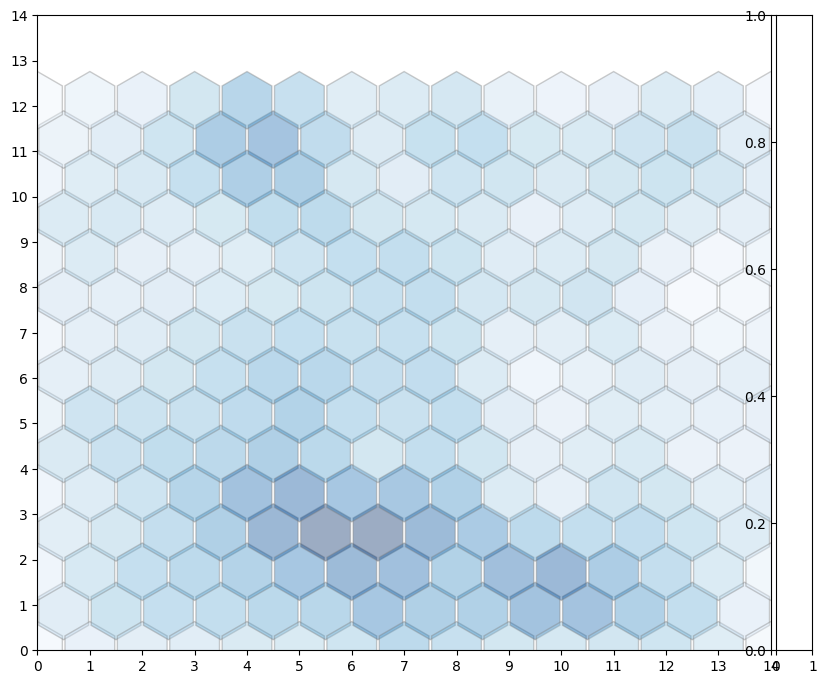

In [21]:
# Create a figure for the hexagonal grid visualization
f = plt.figure(figsize=(10,10))
ax = f.add_subplot(111)

ax.set_aspect('equal')

# Create a hexagonal grid for the SOM
for i in range(weights.shape[0]):
    for j in range(weights.shape[1]):
        wy = yy[(i, j)] * np.sqrt(3) / 2
        hex = RegularPolygon((xx[(i, j)], wy),
                             numVertices=6, 
                             radius=.95 / np.sqrt(3), 
                             facecolor=cm.Blues(umatrix[i, j]), 
                             alpha=.4, 
                             edgecolor='gray')
        ax.add_patch(hex)

xrange = np.arange(weights.shape[0])
yrange = np.arange(weights.shape[1])
plt.xticks(xrange-.5, xrange)
plt.yticks(yrange * np.sqrt(3) / 2, yrange)

divider = make_axes_locatable(plt.gca())
ax_cb = divider.new_horizontal(size="5%", pad=0.05)    
plt.gcf().add_axes(ax_cb)

Start mapping cells to neurons

In [22]:
train_embeddings_subset
x = train_embeddings_subset[0,]
w = som.winner(x)
print(w)

(np.int64(9), np.int64(11))


In [23]:
# Dictionary to store SOM winners and their corresponding row indices
winner_to_rows = {}

# List to track which winner corresponds to each row
row_to_winner = []

# Iterate over all rows in train_embeddings_subset
for idx, row in enumerate(train_embeddings_subset):
    winner = som.winner(row)
    row_to_winner.append(winner)
    
    # Add the row index to the corresponding winner in the dictionary
    if winner not in winner_to_rows:
        winner_to_rows[winner] = []
    winner_to_rows[winner].append(idx)

# Example: Output the dictionary and list
print("Mapping of winners to row indices:", winner_to_rows)
print("Mapping of rows to winners:", row_to_winner)


Mapping of winners to row indices: {(np.int64(9), np.int64(11)): [0, 5, 85, 110, 124, 238, 262, 270, 321, 483, 487, 604, 712], (np.int64(1), np.int64(4)): [1, 170, 175, 216], (np.int64(2), np.int64(10)): [2, 57, 89, 177, 191, 290, 785], (np.int64(0), np.int64(12)): [3, 13, 51, 70, 118, 121, 134, 155, 198, 205, 213, 389, 415, 828], (np.int64(3), np.int64(9)): [4, 9, 15, 31, 53, 130, 140, 186, 193, 354], (np.int64(9), np.int64(4)): [6, 133, 242, 272, 305, 322, 482, 580, 685, 727, 775, 794, 804, 821, 854], (np.int64(6), np.int64(5)): [7, 275, 288, 320, 350, 457, 600, 825], (np.int64(5), np.int64(9)): [8, 17, 195, 326, 622, 661, 809, 884], (np.int64(0), np.int64(5)): [10, 111, 942], (np.int64(3), np.int64(6)): [11, 113, 146], (np.int64(3), np.int64(14)): [12, 84, 562, 584, 693, 718], (np.int64(3), np.int64(12)): [14, 475], (np.int64(12), np.int64(12)): [16, 75, 144, 149, 203, 553, 859], (np.int64(2), np.int64(14)): [18, 42, 276, 419, 566, 579, 617, 653], (np.int64(3), np.int64(1)): [19, 88

In [24]:
subset_adata_train.obs['clone_id']

d2_3:GCGCTGATTAGCCTCG     Lineage_1626
d2_3:CGTTGCCTCACAGTTT     Lineage_5039
d2_3:AGCACGTAAAAGTCGG     Lineage_4141
d2_3:TCCGACACTCGTCATG     Lineage_2448
d2_3:GTCTGGAACCTATTCA      Lineage_336
                              ...     
LK_d2:CCAGCGAATCGTCATG     Lineage_593
LK_d2:CGTGTGTTTTAAGCGT    Lineage_4929
LK_d2:GTTACTAGCCCTTCAG    Lineage_2319
LK_d2:CCCTTGCATTGGCGTT    Lineage_3016
LK_d2:GGTTACACCCGCAACT    Lineage_5801
Name: clone_id, Length: 966, dtype: object

In [25]:
# Assuming you already have `winner_to_rows` from the previous part

# Dictionary to store the average Monocyte_proportion for each neuron
neuron_to_monocyte_avg = {}

# Iterate over each node in `winner_to_rows`
for winner, rows in winner_to_rows.items():
    # Get all the clone_ids for the rows that map to this neuron
    clone_ids = subset_adata_train.obs.iloc[rows]['clone_id']
    
    # Initialize a list to store Monocyte_proportion values
    monocyte_proportions = []
    
    # Loop over each clone_id to find its Monocyte_proportion from `df`
    for clone_id in clone_ids:
        # Ensure clone_id format matches the one in df (remove "Lineage_" prefix if necessary)
        lineage_id = clone_id
        
        # Find the row in `df` that corresponds to this lineage_id
        monocyte_value = df[df['Unnamed: 0'] == lineage_id]['Monocyte_proportion'].values
        
        if len(monocyte_value) > 0:  # Ensure the clone_id exists in df
            monocyte_proportions.append(monocyte_value[0])
    
    # Compute the mean Monocyte_proportion for this neuron
    if len(monocyte_proportions) > 0:
        avg_monocyte_proportion = np.mean(monocyte_proportions)
    else:
        avg_monocyte_proportion = np.nan  # If no values were found, store NaN
    
    # Store the result for this neuron
    neuron_to_monocyte_avg[winner] = avg_monocyte_proportion

# Example: Output the dictionary containing average Monocyte_proportion per neuron
print(neuron_to_monocyte_avg)


{(np.int64(9), np.int64(11)): np.float64(0.8666229603729604), (np.int64(1), np.int64(4)): np.float64(0.25), (np.int64(2), np.int64(10)): np.float64(0.10587560587560571), (np.int64(0), np.int64(12)): np.float64(0.00274725274725275), (np.int64(3), np.int64(9)): np.float64(0.8107142857142857), (np.int64(9), np.int64(4)): np.float64(0.0039215686274509795), (np.int64(6), np.int64(5)): np.float64(0.0), (np.int64(5), np.int64(9)): np.float64(0.8175108225108225), (np.int64(0), np.int64(5)): np.float64(0.038647342995169), (np.int64(3), np.int64(6)): np.float64(0.0), (np.int64(3), np.int64(14)): np.float64(0.0), (np.int64(3), np.int64(12)): np.float64(0.6764705882352939), (np.int64(12), np.int64(12)): np.float64(0.8426587301587302), (np.int64(2), np.int64(14)): np.float64(0.08705357142857137), (np.int64(3), np.int64(1)): np.float64(0.0555555555555555), (np.int64(0), np.int64(4)): np.float64(0.09523809523809522), (np.int64(6), np.int64(8)): np.float64(0.6125), (np.int64(12), np.int64(9)): np.floa

In [26]:
neuron_to_monocyte_avg

{(np.int64(9), np.int64(11)): np.float64(0.8666229603729604),
 (np.int64(1), np.int64(4)): np.float64(0.25),
 (np.int64(2), np.int64(10)): np.float64(0.10587560587560571),
 (np.int64(0), np.int64(12)): np.float64(0.00274725274725275),
 (np.int64(3), np.int64(9)): np.float64(0.8107142857142857),
 (np.int64(9), np.int64(4)): np.float64(0.0039215686274509795),
 (np.int64(6), np.int64(5)): np.float64(0.0),
 (np.int64(5), np.int64(9)): np.float64(0.8175108225108225),
 (np.int64(0), np.int64(5)): np.float64(0.038647342995169),
 (np.int64(3), np.int64(6)): np.float64(0.0),
 (np.int64(3), np.int64(14)): np.float64(0.0),
 (np.int64(3), np.int64(12)): np.float64(0.6764705882352939),
 (np.int64(12), np.int64(12)): np.float64(0.8426587301587302),
 (np.int64(2), np.int64(14)): np.float64(0.08705357142857137),
 (np.int64(3), np.int64(1)): np.float64(0.0555555555555555),
 (np.int64(0), np.int64(4)): np.float64(0.09523809523809522),
 (np.int64(6), np.int64(8)): np.float64(0.6125),
 (np.int64(12), np.i

In [27]:
import numpy as np

# Initialize a 15x15 array with 0.5 everywhere
monocyte_grid = np.full((grid_size, grid_size), 0.0)

# Iterate over the neuron_to_monocyte_avg dictionary and update the corresponding locations
for (x, y), monocyte_avg in neuron_to_monocyte_avg.items():
    monocyte_grid[x, y] = monocyte_avg  # Update the value at the grid position (x, y)

# Example: Output the resulting grid
print(monocyte_grid)

[[0.         0.         0.         0.         0.0952381  0.03864734
  0.09387279 0.15897436 0.07539788 0.         0.37962963 0.14285714
  0.00274725 0.47058824 0.        ]
 [0.         0.1        0.         0.5        0.25       0.18134921
  0.18181818 0.         0.25       0.21759858 0.09090909 0.25806452
  0.         0.         0.        ]
 [0.08333333 0.         0.         0.75       0.         0.
  0.         0.         0.21471861 0.38888889 0.10587561 0.
  0.         0.         0.08705357]
 [0.         0.05555556 0.08333333 0.15191041 0.         0.66666667
  0.         0.83333333 0.09615385 0.81071429 0.5        0.875
  0.67647059 0.         0.        ]
 [0.         0.12564123 0.08333333 0.25       0.         0.00617284
  0.33333333 0.875      0.84722222 0.625      0.875      0.75134409
  0.43589744 0.33333333 0.0452381 ]
 [0.         0.1287223  0.23388889 0.         0.         0.
  0.         0.10465116 0.91111111 0.81751082 0.60952381 0.
  0.47058824 0.         0.61818182]
 [0.4

<Axes: >

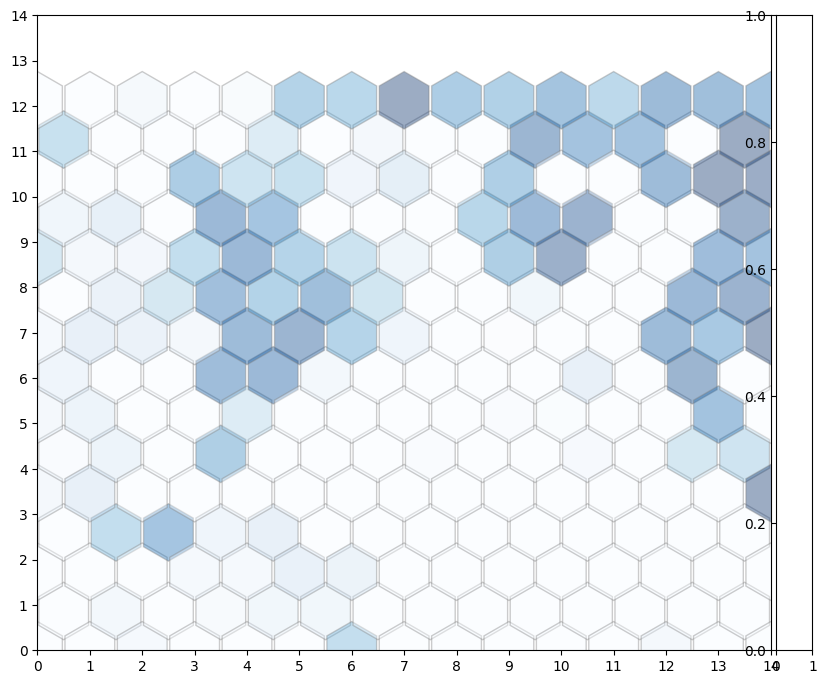

In [28]:
# Create a figure for the hexagonal grid visualization
f = plt.figure(figsize=(10,10))
ax = f.add_subplot(111)

ax.set_aspect('equal')

# Create a hexagonal grid for the SOM
for i in range(weights.shape[0]):
    for j in range(weights.shape[1]):
        wy = yy[(i, j)] * np.sqrt(3) / 2
        hex = RegularPolygon((xx[(i, j)], wy),
                             numVertices=6, 
                             radius=.95 / np.sqrt(3), 
                             facecolor=cm.Blues(monocyte_grid[i, j]), 
                             alpha=.4, 
                             edgecolor='gray')
        ax.add_patch(hex)

xrange = np.arange(weights.shape[0])
yrange = np.arange(weights.shape[1])
plt.xticks(xrange-.5, xrange)
plt.yticks(yrange * np.sqrt(3) / 2, yrange)

divider = make_axes_locatable(plt.gca())
ax_cb = divider.new_horizontal(size="5%", pad=0.05)    
plt.gcf().add_axes(ax_cb)

In [29]:
# Assuming you already have `winner_to_rows` from the previous part

# Dictionary to store the average neutrophil_proportion for each neuron
neuron_to_neutrophil_avg = {}

# Iterate over each node in `winner_to_rows`
for winner, rows in winner_to_rows.items():
  # Get all the clone_ids for the rows that map to this neuron
  clone_ids = subset_adata_train.obs.iloc[rows]['clone_id']
  
  # Initialize a list to store neutrophil_proportion values
  neutrophil_proportions = []
  
  # Loop over each clone_id to find its neutrophil_proportion from `df`
  for clone_id in clone_ids:
    # Ensure clone_id format matches the one in df (remove "Lineage_" prefix if necessary)
    lineage_id = clone_id
  
  # Find the row in `df` that corresponds to this lineage_id
  neutrophil_value = df[df['Unnamed: 0'] == lineage_id]['Neutrophil_proportion'].values
  
  if len(neutrophil_value) > 0:  # Ensure the clone_id exists in df
    neutrophil_proportions.append(neutrophil_value[0])
  
  # Compute the mean neutrophil_proportion for this neuron
  if len(neutrophil_proportions) > 0:
    avg_neutrophil_proportion = np.mean(neutrophil_proportions)
  else:
    avg_neutrophil_proportion = np.nan  # If no values were found, store NaN
  
  # Store the result for this neuron
  neuron_to_neutrophil_avg[winner] = avg_neutrophil_proportion

In [30]:
# Initialize a 15x15 array with 0.5 everywhere
neutrophil_grid = np.full((grid_size, grid_size), 0.0)

# Iterate over the neuron_to_neutrophil_avg dictionary and update the corresponding locations
for (x, y), neutrophil_avg in neuron_to_neutrophil_avg.items():
  neutrophil_grid[x, y] = neutrophil_avg  # Update the value at the grid position (x, y)

In [31]:
neutrophil_grid

array([[1.        , 1.        , 1.        , 1.        , 0.75      ,
        0.79710145, 0.85714286, 1.        , 1.        , 0.6       ,
        0.93258427, 0.57142857, 0.93333333, 0.23529412, 0.        ],
       [1.        , 0.95652174, 1.        , 1.        , 1.        ,
        0.73333333, 0.72727273, 0.41666667, 0.5       , 1.        ,
        0.90909091, 0.64516129, 0.71428571, 1.        , 1.        ],
       [1.        , 0.875     , 0.        , 0.        , 0.        ,
        0.        , 0.        , 1.        , 0.33333333, 0.5       ,
        0.        , 0.        , 0.        , 1.        , 1.        ],
       [1.        , 1.        , 1.        , 0.63636364, 0.        ,
        0.75      , 0.33333333, 0.5       , 0.66666667, 0.5       ,
        0.        , 0.5       , 0.        , 0.        , 0.92307692],
       [1.        , 1.        , 1.        , 0.75      , 0.        ,
        0.8       , 0.33333333, 0.        , 0.        , 0.        ,
        0.        , 0.25      , 0.35897436, 

<Axes: >

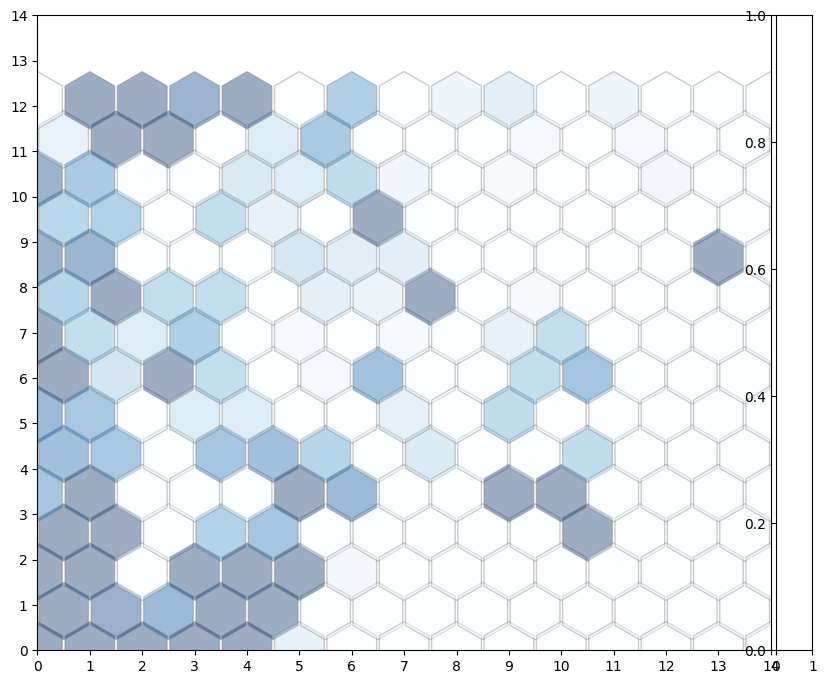

In [32]:
# Create a figure for the hexagonal grid visualization
f = plt.figure(figsize=(10,10))
ax = f.add_subplot(111)

ax.set_aspect('equal')

# Create a hexagonal grid for the SOM
for i in range(weights.shape[0]):
    for j in range(weights.shape[1]):
        wy = yy[(i, j)] * np.sqrt(3) / 2
        hex = RegularPolygon((xx[(i, j)], wy),
                             numVertices=6, 
                             radius=.95 / np.sqrt(3), 
                             facecolor=cm.Blues(neutrophil_grid[i, j]), 
                             alpha=0.4, 
                             edgecolor='gray')
        ax.add_patch(hex)

xrange = np.arange(weights.shape[0])
yrange = np.arange(weights.shape[1])
plt.xticks(xrange-.5, xrange)
plt.yticks(yrange * np.sqrt(3) / 2, yrange)

divider = make_axes_locatable(plt.gca())
ax_cb = divider.new_horizontal(size="5%", pad=0.05)    
plt.gcf().add_axes(ax_cb)

In [33]:
neutrophil_grid

array([[1.        , 1.        , 1.        , 1.        , 0.75      ,
        0.79710145, 0.85714286, 1.        , 1.        , 0.6       ,
        0.93258427, 0.57142857, 0.93333333, 0.23529412, 0.        ],
       [1.        , 0.95652174, 1.        , 1.        , 1.        ,
        0.73333333, 0.72727273, 0.41666667, 0.5       , 1.        ,
        0.90909091, 0.64516129, 0.71428571, 1.        , 1.        ],
       [1.        , 0.875     , 0.        , 0.        , 0.        ,
        0.        , 0.        , 1.        , 0.33333333, 0.5       ,
        0.        , 0.        , 0.        , 1.        , 1.        ],
       [1.        , 1.        , 1.        , 0.63636364, 0.        ,
        0.75      , 0.33333333, 0.5       , 0.66666667, 0.5       ,
        0.        , 0.5       , 0.        , 0.        , 0.92307692],
       [1.        , 1.        , 1.        , 0.75      , 0.        ,
        0.8       , 0.33333333, 0.        , 0.        , 0.        ,
        0.        , 0.25      , 0.35897436, 

In [34]:
total_grid = neutrophil_grid-monocyte_grid
print(total_grid)

[[ 1.00000000e+00  1.00000000e+00  1.00000000e+00  1.00000000e+00
   6.54761905e-01  7.58454106e-01  7.63270063e-01  8.41025641e-01
   9.24602122e-01  6.00000000e-01  5.52954640e-01  4.28571429e-01
   9.30586081e-01 -2.35294118e-01  0.00000000e+00]
 [ 1.00000000e+00  8.56521739e-01  1.00000000e+00  5.00000000e-01
   7.50000000e-01  5.51984127e-01  5.45454545e-01  4.16666667e-01
   2.50000000e-01  7.82401422e-01  8.18181818e-01  3.87096774e-01
   7.14285714e-01  1.00000000e+00  1.00000000e+00]
 [ 9.16666667e-01  8.75000000e-01  0.00000000e+00 -7.50000000e-01
   0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00
   1.18614719e-01  1.11111111e-01 -1.05875606e-01  0.00000000e+00
   0.00000000e+00  1.00000000e+00  9.12946429e-01]
 [ 1.00000000e+00  9.44444444e-01  9.16666667e-01  4.84453228e-01
   0.00000000e+00  8.33333333e-02  3.33333333e-01 -3.33333333e-01
   5.70512821e-01 -3.10714286e-01 -5.00000000e-01 -3.75000000e-01
  -6.76470588e-01  0.00000000e+00  9.23076923e-01]
 [ 1

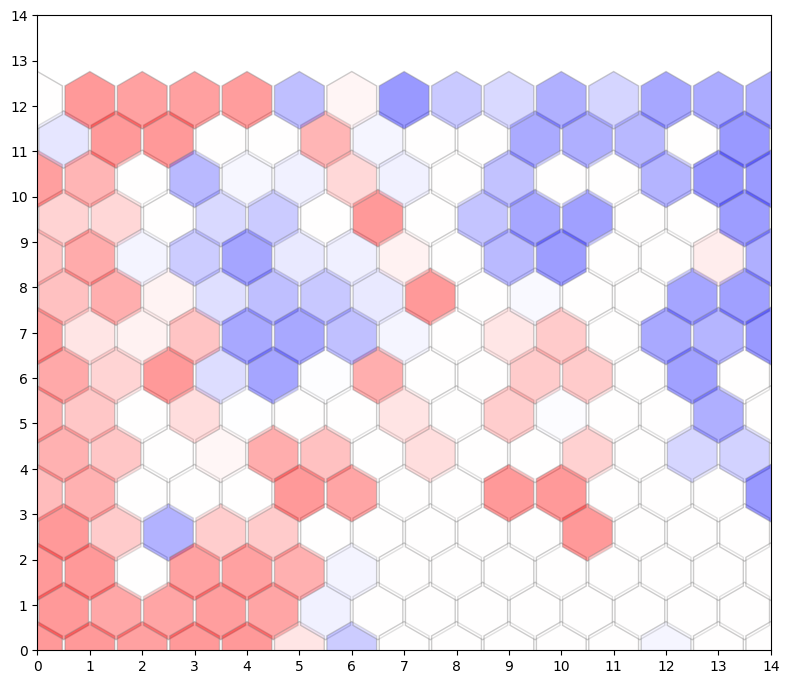

In [35]:
import matplotlib.pyplot as plt
from matplotlib.patches import RegularPolygon
from mpl_toolkits.axes_grid1 import make_axes_locatable
import numpy as np
import matplotlib.cm as cm

# Create a figure for the hexagonal grid visualization
f = plt.figure(figsize=(10,10))
ax = f.add_subplot(111)

ax.set_aspect('equal')

# Normalize the values in total_grid to be between -1 and 1
norm_total_grid = (total_grid + 1) / 2  # This normalizes -1 to 0, 0 to 0.5, and 1 to 1

# Create a hexagonal grid for the SOM
for i in range(weights.shape[0]):
    for j in range(weights.shape[1]):
        wy = yy[(i, j)] * np.sqrt(3) / 2
        # Use cm.bwr for red-white-blue colormap
        hex = RegularPolygon((xx[(i, j)], wy),
                             numVertices=6, 
                             radius=.95 / np.sqrt(3), 
                             facecolor=cm.bwr(norm_total_grid[i, j]), 
                             alpha=.4, 
                             edgecolor='gray')
        ax.add_patch(hex)

xrange = np.arange(weights.shape[0])
yrange = np.arange(weights.shape[1])
plt.xticks(xrange-.5, xrange)
plt.yticks(yrange * np.sqrt(3) / 2, yrange)

# Add colorbar
divider = make_axes_locatable(plt.gca())
ax_cb = divider.new_horizontal(size="5%", pad=0.05)    
cb = plt.colorbar(cm.ScalarMappable(cmap=cm.bwr), cax=ax_cb)
cb.set_ticks([-1, 0, 1])
cb.set_ticklabels(['-1', '0', '1'])
cb.set_label('Value range (-1 to 1)')

plt.show()


In [36]:
# Assume total_grid is the array you have with values between -1 and 1

# Iterate through all neurons and check if they are in winner_to_rows
for i in range(total_grid.shape[0]):
    for j in range(total_grid.shape[1]):
        if (np.int64(i), np.int64(j)) not in winner_to_rows:
            total_grid[i, j] = np.nan  # Set to np.nan if no cells are mapped to this neuron


In [37]:
total_grid

array([[ 1.00000000e+00,  1.00000000e+00,  1.00000000e+00,
         1.00000000e+00,  6.54761905e-01,  7.58454106e-01,
         7.63270063e-01,  8.41025641e-01,  9.24602122e-01,
         6.00000000e-01,  5.52954640e-01,  4.28571429e-01,
         9.30586081e-01, -2.35294118e-01,  0.00000000e+00],
       [ 1.00000000e+00,  8.56521739e-01,  1.00000000e+00,
         5.00000000e-01,  7.50000000e-01,  5.51984127e-01,
         5.45454545e-01,  4.16666667e-01,  2.50000000e-01,
         7.82401422e-01,  8.18181818e-01,  3.87096774e-01,
         7.14285714e-01,  1.00000000e+00,  1.00000000e+00],
       [ 9.16666667e-01,  8.75000000e-01,             nan,
        -7.50000000e-01,  0.00000000e+00,             nan,
                    nan,  1.00000000e+00,  1.18614719e-01,
         1.11111111e-01, -1.05875606e-01,             nan,
                    nan,  1.00000000e+00,  9.12946429e-01],
       [ 1.00000000e+00,  9.44444444e-01,  9.16666667e-01,
         4.84453228e-01,             nan,  8.33333333

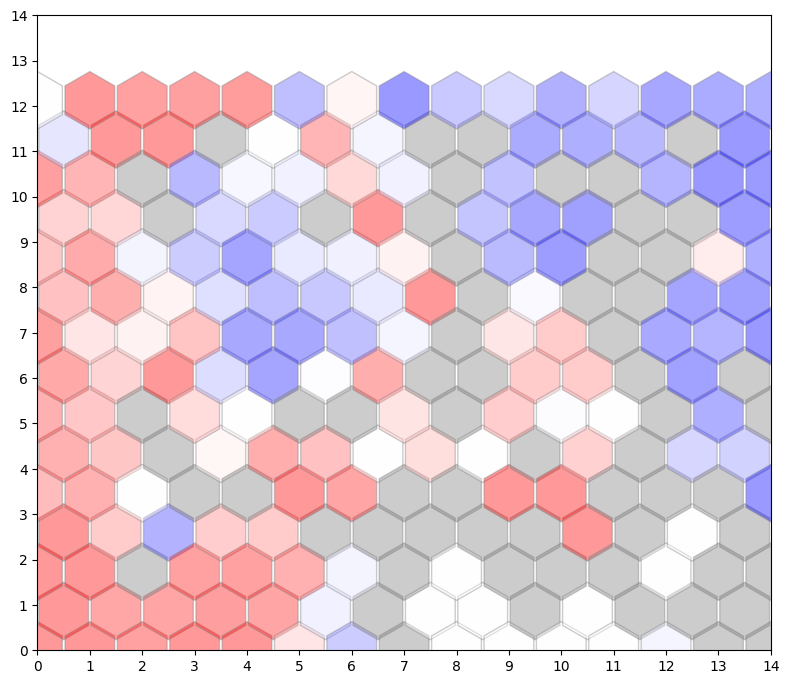

In [38]:
import matplotlib.pyplot as plt
from matplotlib.patches import RegularPolygon
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.cm as cm

# Create a figure for the hexagonal grid visualization
f = plt.figure(figsize=(10,10))
ax = f.add_subplot(111)

ax.set_aspect('equal')

# Normalize the values in total_grid to be between -1 and 1 (ignoring NaNs)
norm_total_grid = (total_grid + 1) / 2  # Normalize -1 to 0, 0 to 0.5, and 1 to 1

# Create a hexagonal grid for the SOM
for i in range(weights.shape[0]):
    for j in range(weights.shape[1]):
        wy = yy[(i, j)] * np.sqrt(3) / 2
        if np.isnan(total_grid[i, j]):  # Gray out neurons with NaN values
            hex_color = 'gray'
        else:
            hex_color = cm.bwr(norm_total_grid[i, j])  # Use the bwr colormap for others
        hex = RegularPolygon((xx[(i, j)], wy),
                             numVertices=6, 
                             radius=.95 / np.sqrt(3), 
                             facecolor=hex_color, 
                             alpha=.4, 
                             edgecolor='gray')
        ax.add_patch(hex)

xrange = np.arange(weights.shape[0])
yrange = np.arange(weights.shape[1])
plt.xticks(xrange-.5, xrange)
plt.yticks(yrange * np.sqrt(3) / 2, yrange)

# Add colorbar
divider = make_axes_locatable(plt.gca())
ax_cb = divider.new_horizontal(size="5%", pad=0.05)    
cb = plt.colorbar(cm.ScalarMappable(cmap=cm.bwr), cax=ax_cb)
cb.set_ticks([-1, 0, 1])
cb.set_ticklabels(['-1', '0', '1'])
cb.set_label('Value range (-1 to 1)')

plt.show()


In [39]:
def get_neighbors(i, j, cluster_grid, total_grid):
    neighbors = []
    cluster_id = cluster_grid[i, j]
    directions = [(-1, 0), (1, 0), (0, -1), (0, 1)]  # Up, down, left, right

    for di, dj in directions:
        ni, nj = i + di, j + dj
        # Check if the neighbor is within bounds and in the same cluster
        if 0 <= ni < cluster_grid.shape[0] and 0 <= nj < cluster_grid.shape[1]:
            if cluster_grid[ni, nj] == cluster_id:
                if not np.isnan(total_grid[ni, nj]):
                    neighbors.append(total_grid[ni, nj])

    return neighbors


In [40]:
# Iterate through the total_grid and impute NaN values
for i in range(total_grid.shape[0]):
    for j in range(total_grid.shape[1]):
        if np.isnan(total_grid[i, j]):  # If the value is NaN
            # Get the neighboring neurons in the same cluster
            neighbors = get_neighbors(i, j, segments, total_grid)
            if neighbors:  # If there are valid non-NaN neighbors
                total_grid[i, j] = np.mean(neighbors)  # Impute with the average


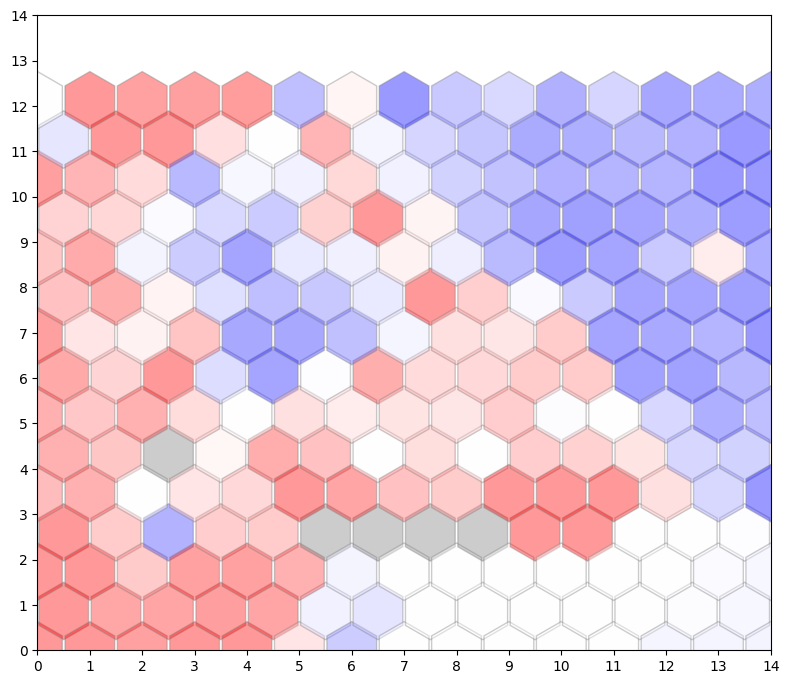

In [41]:
import matplotlib.pyplot as plt
from matplotlib.patches import RegularPolygon
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.cm as cm

# Create a figure for the hexagonal grid visualization
f = plt.figure(figsize=(10,10))
ax = f.add_subplot(111)

ax.set_aspect('equal')

# Normalize the values in total_grid to be between -1 and 1 (ignoring NaNs)
norm_total_grid = (total_grid + 1) / 2  # Normalize -1 to 0, 0 to 0.5, and 1 to 1

# Create a hexagonal grid for the SOM
for i in range(weights.shape[0]):
    for j in range(weights.shape[1]):
        wy = yy[(i, j)] * np.sqrt(3) / 2
        if np.isnan(total_grid[i, j]):  # Gray out neurons with NaN values
            hex_color = 'gray'
        else:
            hex_color = cm.bwr(norm_total_grid[i, j])  # Use the bwr colormap for others
        hex = RegularPolygon((xx[(i, j)], wy),
                             numVertices=6, 
                             radius=.95 / np.sqrt(3), 
                             facecolor=hex_color, 
                             alpha=0.4, 
                             edgecolor='gray')
        ax.add_patch(hex)

xrange = np.arange(weights.shape[0])
yrange = np.arange(weights.shape[1])
plt.xticks(xrange-.5, xrange)
plt.yticks(yrange * np.sqrt(3) / 2, yrange)

# Add colorbar
divider = make_axes_locatable(plt.gca())
ax_cb = divider.new_horizontal(size="5%", pad=0.05)    
cb = plt.colorbar(cm.ScalarMappable(cmap=cm.bwr), cax=ax_cb)
cb.set_ticks([-1, 0, 1])
cb.set_ticklabels(['-1', '0', '1'])
cb.set_label('Value range (-1 to 1)')

plt.show()


In [42]:
# Iterate through the total_grid and impute NaN values
for i in range(total_grid.shape[0]):
    for j in range(total_grid.shape[1]):
        # Get the neighboring neurons in the same cluster
            neighbors = get_neighbors(i, j, segments, total_grid)
            if neighbors:  # If there are valid non-NaN neighbors
                total_grid[i, j] = np.mean(neighbors)  # Impute with the average
            


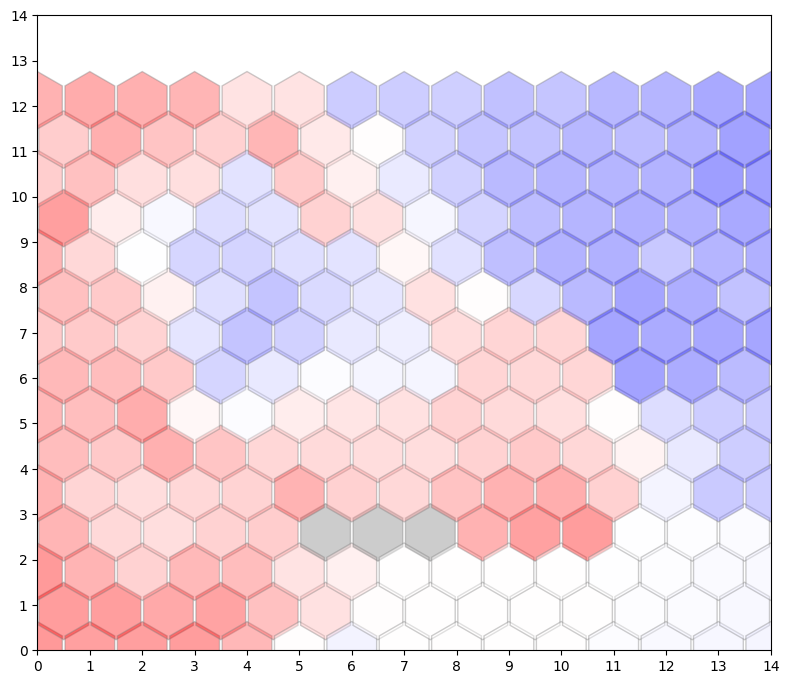

In [43]:
import matplotlib.pyplot as plt
from matplotlib.patches import RegularPolygon
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.cm as cm

# Create a figure for the hexagonal grid visualization
f = plt.figure(figsize=(10,10))
ax = f.add_subplot(111)

ax.set_aspect('equal')

# Normalize the values in total_grid to be between -1 and 1 (ignoring NaNs)
norm_total_grid = (total_grid + 1) / 2  # Normalize -1 to 0, 0 to 0.5, and 1 to 1

# Create a hexagonal grid for the SOM
for i in range(weights.shape[0]):
    for j in range(weights.shape[1]):
        wy = yy[(i, j)] * np.sqrt(3) / 2
        if np.isnan(total_grid[i, j]):  # Gray out neurons with NaN values
            hex_color = 'gray'
        else:
            hex_color = cm.bwr(norm_total_grid[i, j])  # Use the bwr colormap for others
        hex = RegularPolygon((xx[(i, j)], wy),
                             numVertices=6, 
                             radius=.95 / np.sqrt(3), 
                             facecolor=hex_color, 
                             alpha=0.4, 
                             edgecolor='gray')
        ax.add_patch(hex)

xrange = np.arange(weights.shape[0])
yrange = np.arange(weights.shape[1])
plt.xticks(xrange-.5, xrange)
plt.yticks(yrange * np.sqrt(3) / 2, yrange)

# Add colorbar
divider = make_axes_locatable(plt.gca())
ax_cb = divider.new_horizontal(size="5%", pad=0.05)    
cb = plt.colorbar(cm.ScalarMappable(cmap=cm.bwr), cax=ax_cb)
cb.set_ticks([-1, 0, 1])
cb.set_ticklabels(['-1', '0', '1'])
cb.set_label('Value range (-1 to 1)')

plt.show()
